## As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away. Your goal is to predict the values of single unit properties using the obervations from 2017.

## In these exercises, you will complete the first step toward the above goal: acquire and prepare the necessary Zillow data from the zillow database in the Codeup database server.

## Acquire bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, and fips from the zillow database for all 'Single Family Residential' properties.

## Using your acquired Zillow data, walk through the summarization and cleaning steps in your wrangle.ipynb file like we did above. You may handle the missing values however you feel is appropriate and meaninful; remember to document your process and decisions using markdown and code commenting where helpful.

## Store all of the necessary functions to automate your process from acquiring the data to returning a cleaned dataframe witn no missing values in your wrangle.py file. Name your final function wrangle_zillow.

# Imports

In [20]:
from env import user, password, host
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
url = f"mysql+pymysql://{user}:{password}@{host}/zillow"
    
query = """
            
SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
FROM properties_2017

LEFT JOIN propertylandusetype USING(propertylandusetypeid)

WHERE propertylandusedesc IN ("Single Family Residential", 
                              "Mobile Home", 
                              "Manufactured\, Modular\, Prefabricated Homes",
                              "Inferred Single Family Residential",
                              "Patio Home")"""
    
df = pd.read_sql(query, url)
df

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0
...,...,...,...,...,...,...,...
2213422,4.0,4.5,3127.0,536061.0,2014.0,6244.16,6059.0
2213423,0.0,0.0,NaN,208057.0,NaN,5783.88,6059.0
2213424,3.0,2.5,1974.0,424353.0,2015.0,5302.70,6059.0
2213425,2.0,1.0,798.0,469300.0,2006.0,5764.45,6037.0


## Are there any Null values?

In [3]:
# get total of null values for each row
df.isnull().sum()

bedroomcnt                         11
bathroomcnt                        11
calculatedfinishedsquarefeet    33034
taxvaluedollarcnt               30986
yearbuilt                       32982
taxamount                       15263
fips                                0
dtype: int64

* dropping rows with nulls in bedroomcnt and bathroomcnt because there are very few of them
* dropping rows with nulls in taxvalue dollor count, training the model to asociate data with a calculated column seems dubious

In [4]:
df = df.dropna(subset = ['bedroomcnt','bathroomcnt', 'taxvaluedollarcnt'])

In [5]:
df.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet    31366
taxvaluedollarcnt                   0
yearbuilt                       31949
taxamount                        8347
fips                                0
dtype: int64

* dropping column taxamount because it contains target leak

In [6]:
df = df.drop(columns = 'taxamount')

In [7]:
df.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet    31366
taxvaluedollarcnt                   0
yearbuilt                       31949
fips                                0
dtype: int64

In [8]:
# consider imputing year built
df.yearbuilt.value_counts()

1955.0    84404
1950.0    71687
1954.0    69161
1953.0    62339
1956.0    61942
          ...  
1879.0        1
1877.0        1
1855.0        1
1874.0        1
1823.0        1
Name: yearbuilt, Length: 153, dtype: int64

* because the number of rows with missing data in yearbuilt is almost half the number of the most frequent value, imputing the data using any one value would significantly skew the data I will therefore drop the rows containing nulls in this column

In [10]:
df = df.dropna(subset = ['yearbuilt'])

df.isnull().sum()

bedroomcnt                        0
bathroomcnt                       0
calculatedfinishedsquarefeet    899
taxvaluedollarcnt                 0
yearbuilt                         0
fips                              0
dtype: int64

In [11]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
df.describe()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips
count,2150481,2150481,2149582,2150481,2150481,2150481
mean,3,2,1862,459531,1961,6048
std,1,1,1221,678206,22,21
min,0,0,1,1,1801,6037
25%,3,2,1257,187830,1949,6037
50%,3,2,1621,327117,1958,6037
75%,4,3,2206,533298,1976,6059
max,25,32,952576,90188462,2016,6111


In [12]:
pd.reset_option('display.float_format')

* Given the extream outliers, I plan on imputing calculatedfinishedsquarefeet based on the median or mode once the data is split

## Are the column data types correct?

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2150481 entries, 4 to 2213426
Data columns (total 6 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   fips                          float64
dtypes: float64(6)
memory usage: 114.8 MB


In [17]:
# get value counts and decide on data types
cols = df.columns

for col in cols:
    
    print(col.upper())
    print(df[col].value_counts())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print()

BEDROOMCNT
3     965162
4     634254
2     336127
5     150806
6      25159
1      23062
0       9507
7       4805
8       1106
9        290
10       121
11        34
13        15
12        13
14         7
15         6
16         3
18         3
25         1
Name: bedroomcnt, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

BATHROOMCNT
2.00     945720
3.00     422786
1.00     413833
2.50     142862
4.00      82139
1.50      31168
3.50      28474
5.00      28352
4.50      19477
6.00      10746
0.00       9358
5.50       6202
7.00       4395
8.00       1688
6.50       1330
9.00        712
7.50        382
10.00       326
11.00       145
8.50        108
12.00        74
9.50         50
13.00        39
14.00        25
15.00        17
0.50         16
10.50        14
16.00        12
18.00         8
20.00         6
17.00         4
1.75          3
12.50         3
11.50         3
14.50         1
32.00         1
19.50         1
19.00         1
Name: bathroomcnt, dtype: int64
~~~~~~~~~~~~~~~~~~~~~

* casting fips and year built as an object because it is a numerical represintation of a catagorical value
* leaving the rest as floats

In [15]:
df.fips = df.fips.astype(object)
df.yearbuilt = df.yearbuilt.astype(int)
df.bedroomcnt = df.bedroomcnt.astype(int)

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2150481 entries, 4 to 2213426
Data columns (total 6 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    int64  
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     int64  
 5   fips                          object 
dtypes: float64(3), int64(2), object(1)
memory usage: 114.8+ MB


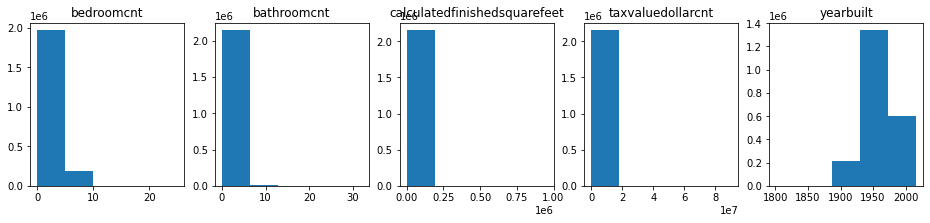

In [18]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in df.columns if col != 'fips']

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,5, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)

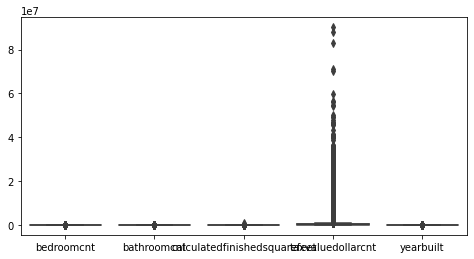

In [23]:
plt.figure(figsize=(8,4))


sns.boxplot(data=df.drop(columns=['fips']))
plt.show()